# Построение модели классификации изображений на основе предобученной модели Vision Transformer

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from zipfile import ZipFile

## Подготовка данных:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset.zip"
# Путь к локальному сессионному хранилищу
LOCAL_DIR = '/content'

# Распаковка архива в сессионное хранилище
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Если архив уже распакован на Google диск, то можно скопировать его в сессионное хранилище
# Сохраняем путь к папке на Google Drive в переменную DRIVE_DIR
DRIVE_DIR = '/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset'

# Копируем выборку в сессионное хранилище
shutil.copytree(DRIVE_DIR, os.path.join(LOCAL_DIR, 'dataset'))

In [ ]:
TRAIN_DIR = os.path.join(LOCAL_DIR, 'dataset/train')
TEST_DIR = os.path.join(LOCAL_DIR, 'dataset/test')

In [ ]:
# Предобработка изображений для подачи на вход ViT и аугментация
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 х 224 - размерность входа ViT
    transforms.RandomHorizontalFlip(p=0.5),  # Зеркальное отражение
    transforms.RandomRotation(degrees=10),  # Случайный поворот
    transforms.ToTensor(),          # Преобразование в тензор в интервале [0, 1] и цветовым каналом на первом месте
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Нормализация
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 х 224 - размерность входа ViT
    transforms.ToTensor(),          # Преобразование в тензор
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Нормализация
])

# Загрузка обучающей и тестовой выборок
train_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(root=TEST_DIR, transform=transform_test)

# Загрузчики данных для выборок (разбивают их на мини-пакеты по 16 шт.)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Проверим названия классов
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['0 - cats', '1 - dogs']


torch.Size([16, 3, 224, 224])
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])


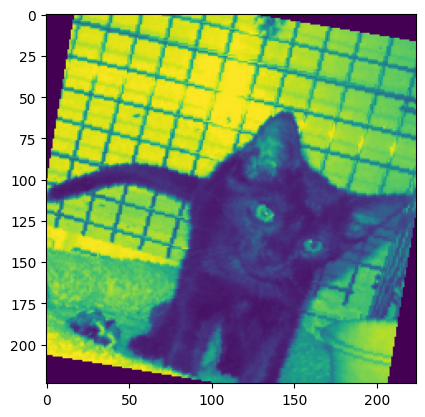

In [ ]:
for image, label in train_loader:
    print(image.shape)
    print(label)
    plt.imshow(image[0][0]) # 0-е изображение, 0-й цветовой канал (красный)
    break

In [ ]:
# Загрузка предобученной модели ViT
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
    id2label={i: label for i, label in enumerate(class_names)},
    label2id={label: i for i, label in enumerate(class_names)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Перемещаем модель на GPU, если он доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определяем алгоритм оптимизации и функцию потерь
optimizer = optim.AdamW(model.parameters(), lr=0.00002)
criterion = nn.CrossEntropyLoss()

# Функция для проведения одной эпохи обучения
def train_one_epoch(model, epoch, train_data_loader, test_data_loader, optimizer, criterion, device):
    model.train()   # переводим модель в режим обучения, включая dropout и batchnorm слои
    total_loss, correct, test_total_loss, test_correct = 0, 0, 0, 0
    progress_bar = tqdm(train_data_loader, desc=f"Epoch {epoch}", leave=True)
    for images, labels in progress_bar:  # перебор обучающей выборки на одной эпохе
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()   # обнуление градиентов, которые остались с предыдущего шага
        outputs = model(pixel_values=images).logits # пропускаем данные батча через модель
        loss = criterion(outputs, labels)   # вычисляем функцию потерь
        loss.backward() # обратное распространение ошибки
        optimizer.step()    # делаем шаг оптимизатора

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

        progress_bar.set_postfix_str(f"Loss: {total_loss / len(train_data_loader):.4f}, Accuracy: {correct / len(train_data_loader.dataset):.4f}")

    # Подсчет метрик и функции потерь на тестовой выборке после окончания эпохи
    model.eval() # переводим модель в режим инференса
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)

            test_total_loss += loss.item()
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_data_loader)
    train_accuracy = correct / len(train_data_loader.dataset)
    test_loss = test_total_loss / len(test_data_loader)
    test_accuracy = test_correct / len(test_data_loader.dataset)
    return train_loss, train_accuracy, test_loss, test_accuracy


In [ ]:
# ViT требует меньше эпох, чем сверточные модели
epochs = 3

for epoch in range(epochs):
    train_loss, train_acc, test_loss, test_acc = train_one_epoch(model, epoch, train_loader, test_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 0: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s, Loss: 0.1335, Accuracy: 0.9832]


Epoch 1/3, Loss: 0.1335, Accuracy: 0.9832, Test Loss: 0.0424, Test Accuracy: 0.9940


Epoch 1: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s, Loss: 0.0229, Accuracy: 0.9960]


Epoch 2/3, Loss: 0.0229, Accuracy: 0.9960, Test Loss: 0.0224, Test Accuracy: 0.9980


Epoch 2: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s, Loss: 0.0138, Accuracy: 0.9978]


Epoch 3/3, Loss: 0.0138, Accuracy: 0.9978, Test Loss: 0.0212, Test Accuracy: 0.9940


Всего после 3 эпох обучения достигнута точность на тестовой выборке 99,4%. Это говорит о высокой эффективности модели Vision Transformer.

## Делаем предсказание для произвольного изображения с помощью обученной модели

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменить размеры к размеру входа модели ViT
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Открыть изображение
    image = transform(image)  # Применить преобразования, заданные выше
    image = image.unsqueeze(0)  # Добавить размерность мини-пакета из одного изображения
    return image.to(device)

def predict(image_path):
    image = preprocess_image(image_path)  # Предобработка изображения
    with torch.no_grad():   # Отключаем вычисление градиентов - нужно только при обучении
        outputs = model(pixel_values=image).logits  # Прогон изображения через модель
        predicted_class = torch.argmax(outputs, dim=1).item()  # Номер выхода с наибольшим сигналом = номеру выходного класса

    return class_names[predicted_class]  # Возвращаем название класса

Predicted class: 0 - cats


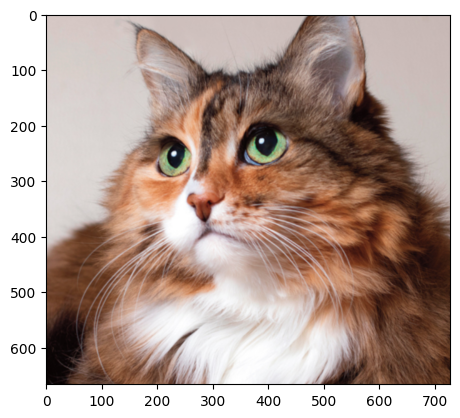

In [ ]:
# Изображение кота
image_path = "cat.png"
plt.imshow(Image.open(image_path))
prediction = predict(image_path)
print(f"Predicted class: {prediction}")

Predicted class: 1 - dogs


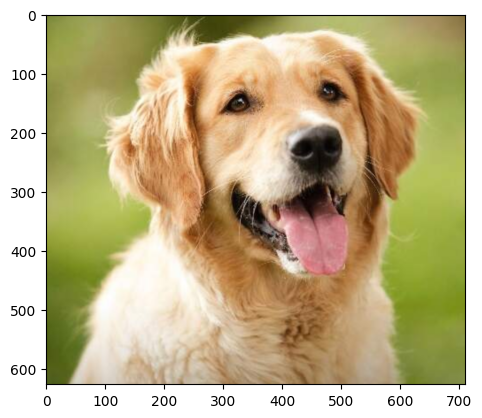

In [ ]:
# Изображение собаки
image_path = "dog.png"
plt.imshow(Image.open(image_path))
prediction = predict(image_path)
print(f"Predicted class: {prediction}")

Обученная модель правильно определяет, кто находится на изображении, с вероятностью более 99%.